# Factor Investing and Asset Pricing Anomalies

## Introduction

The core aim of factor models is to understand the **drivers of asset prices**. The first essential question is which characteristics really provide independent information about average returns?

Theoretically, linear factor models can be viewed as special cases of the arbitrage pricing theory (APT) of Ross (1976), which assumes that the return of an asset $n$ can be modelled as a linear combination of underlying factors $f_k$: $$r_{t,n}=\alpha_n+\sum_{k=1}^K \beta_{n,k}f_{t,k}+\varepsilon_{t,n}$$
Usual constraints: $\mathbb{E}[\varepsilon_{t,n}]=0$, $Cov(\varepsilon_{t,n}, \varepsilon_{t,m})=0$ for $n neq m$ and $Cov(\mathbf{f}_n,\mathbf{\varepsilon}_n)=0$.

If such factors do exist, they are in contradiction with CAPM, and that's why they are called "anomalies". They are further confirmed by Fama and French (1992 and 1993).

## Detecting Anomalies

### Challenges

Researches sometimes cannot be replicated. P-hacking cannot account for all these. Publication can result in fading "anomalies": herding and alpha decay.

### Simple Portfolio Sorting

On one date, 

- Ranking firms according to a particular criterion
- Form $J \geq 2$ portfolios consisting of the same number of stocks
- Equal weighting or proportional to market capitalization
- Report the returns of the portfolios and iterate the process

Outcome $r_t^j$ time series for each grouping $j$. However, this sorting can have **a non-monotonic impact on returns**, thus a test based on two extreme portfolios can be biased. There are other procedures such as covariance structure and multiple criterions.

In the code below, we compute size portfolios (equally weighted: above versus below the median capitalization). According to the size anomaly, the firms with below median market cap should earn higher returns on average. This is verified whenever the orange bar in the plot is above the blue one (it happens most of the time).

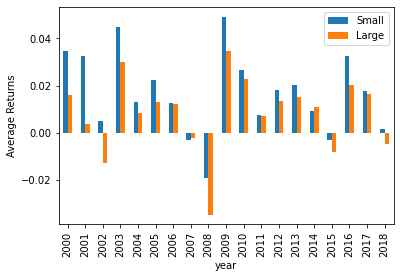

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
data_ml = pd.read_pickle("data/data_ml.pkl")

sub_data = data_ml[['date', 'Mkt_Cap_12M_Usd']]
data_median = sub_data.groupby('date').median()
data_median.columns = ['Mkt_Cap_12M_Usd_M']
data_ml = pd.merge(data_ml, data_median, how = "left", on = "date")
data_ml['large'] = 1 * (data_ml['Mkt_Cap_12M_Usd'] > data_ml['Mkt_Cap_12M_Usd_M'])

data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['year'] = data_ml['date'].apply(lambda x: x.year)
avg_return = data_ml.groupby(['year', 'large']).agg({'R1M_Usd': 'mean'}).unstack()
avg_return.columns = ['Small', 'Large']


avg_return.plot.bar()
plt.ylabel('Average Returns')
plt.xlabel('year')
plt.show()

## Factors
Some most common factors:

- Size (**SMB** = small firms minus large firms)
- Value (**HM** = high minus low; undervalued minus 'growth' firms)
- Momentum (**WML** = winners minus losers): winners are the assets that have experienced the highest returns over the last year
- Profitability (**RMW** = robust minus weak profits)
- Investment (**CMA** = conservative minus aggresive): measured via relative growth of total assets
- Low 'risk' (sometimes, **BAB** = betting against beta)

With the notable exception of the low risk premium, the most mainstream anomalies are kept and updated in the data library of Kenneth French (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). Of course, the computation of the factors follows a particular set of rules, but they are generally accepted in the academic sphere. Another source of data is the AQR repository: https://www.aqr.com/Insights/Datasets.

Below, we import data from Ken French’s data library. We will use it later on in the chapter.

In [14]:
import urllib.request
import shutil

min_date = '1963-07-31'
max_date = '2020-03-28'
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
urllib.request.urlretrieve(ff_url, 'data/factors/factors.zip')

shutil.unpack_archive('data/factors/factors.zip')

In [30]:
df_ff = pd.read_csv('data/factors/F-F_Research_Data_5_Factors_2x3.csv', skiprows = 3, sep = ',', quotechar = '"')
df_ff.rename(columns = {"Unnamed: 0": "date", "Mkt-RF": "MKT_RF"}, inplace = True)
df_ff = df_ff[:714] # Remove year-frequency data

# Deal with dates
df_ff['date'] = pd.to_datetime(df_ff['date'], format = "%Y%m")
df_ff['date'] = df_ff['date'].apply(lambda x: x + pd.DateOffset(months = 1) + pd.DateOffset(days = -1))

df_ff[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = df_ff[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].astype('float64') / 100.0 # Scale returns
FF_factors = df_ff[(df_ff['date'] >= min_date) & (df_ff['date'] <= max_date)]
FF_factors.head()

,date,MKT_RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027


While these factors (i.e., long-short portfolios) exhibit time-varying risk premia and are magnified by corporate news and announcements (Engelberg, McLean, and Pontiff (2018)), it is well-documented (and accepted) that they deliver positive returns over long horizons.

With the following code, we plot the average monthly return aggregated over each calendar year for five common factors. The risk free rate (which is not a factor per se) is the most stable, while the market factor (aggregate market returns minus the risk-free rate) is the most volatile. This makes sense because it is the only long equity factor among the five series.

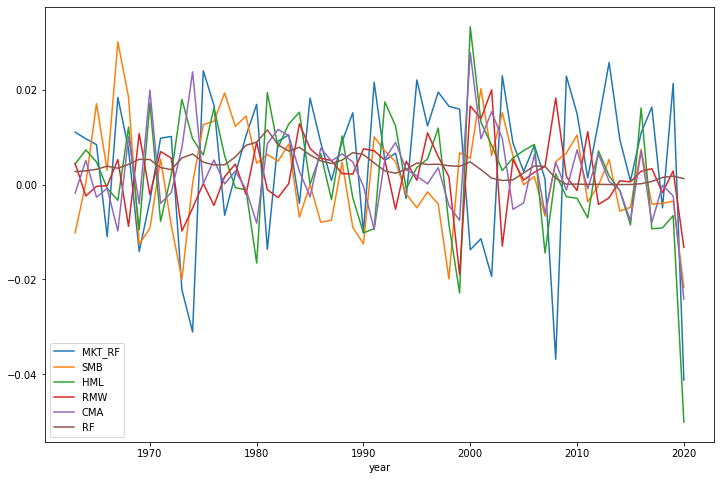

In [43]:
FF_factors['year'] = FF_factors['date'].apply(lambda x: x.year)
FF_factors.groupby('year').mean().plot(figsize = (12, 8))
plt.show()

Finally, we highlight the need of replicability of factor premia and echo the recent editorial by Harvey (2020). As is shown by Linnainmaa and Roberts (2018) and Hou, Xue, and Zhang (2020), many proclaimed factors are in fact very much data-dependent and often fail to deliver sustained profitability when the investment universe is altered or when the definition of variable changes (Clifford Asness and Frazzini (2013)).

A bayesian approach: Fama-Macbeth regression to distinguish between pervasive and superfluous factors.

Publication bias: propensity of journals to publish positive results, leading to a gap between reported returns and true returns. Estimated at roughly 12% (relatively).

### Predictive Regressions, Sorts and P-value Issues

For simplicity, we assume a simple form:
$$\mathbf{r}=a+b\mathbf{x}+\mathbf{e}$$
where the vector $\mathbf{r}$ stacks all returns of all stocks and $\mathbf{x}$ is a lagged variable so that the regression is indeed predictive. If the estimated $\hat{b}$ is significant given a specified threshold, then it can be tempting to conclude that $\mathbf{x}$ does a good job at predicting returns. Hence, long-short portfolios related to extreme values of $\mathbf{x}$ (mind the sign of $\hat{b}$) are expected to generate profits. This is unfortunately **often false** because $\hat{b}$ gives information on the past ability of $\mathbf{x}$ to forecast returns. **What happens in the future may be another story.**

Statistical tests: assuming two extreme portfolio with returns $r_t^+$ and $r_t^-$. The simplest test is $$t=\sqrt{T}\frac{m_{r_+}-m_{r_-}}{\sigma_{r_+-r_-}}$$ where $T$ is number of points, $m_{r_{\pm}}$ is mean of returns and $\sigma_{r_+-r_-}$ is s.t.d. of difference between two series.

Actually, $p$-value is **the likelyhood of your data sample given the distribution (anomaly)**, not the probability of one hypothesis given the data. Harvey introduces **Bayesianized $p$-values**:
$$\text{Bayesianized } p-\text{value}=e^{-t^2/2}\times \frac{prior}{1+e^{-t^2/2}\times prior}$$
where $t$ is the $t$-statistic obtained from the regression. The prior odds are $p/(1-p)$ suppose there is a $p\%$ chance that the null holds (i.e. $(1-p)\%$ for anomaly).

### Fama-Macbeth Regressions

A two-stage regression analysis of risk premia proposed by Fama and MacBeth (1973).

The first stage is a simple estimation of the relationship: run on a stock-by-stock basis over the corresponding time series as following: $$r_{t,n}=\alpha_n+\sum_{k=1}^K \beta_{n,k}f_{t,k}+\varepsilon_{t,n}$$
The resulting estimates $\hat{\beta}_{i,k}$ are then plugged into a second series of regressions: $$r_{t,n}=\gamma_{t,0}+\sum_{k=1}^K \gamma_{t,k}\hat{\beta}_{n,k}+\varepsilon_{t,n}$$ which are run date-by-date on cross-section of assets. The $\hat{\gamma}_{t,k}$ estimate the premia of factor $k$ at time $t$. Under suitable distributional assumptions on $\varepsilon_{t,n}$, statistical tests can be performed to test whether premia are significant. Typically, the statistic on the time-aggregated premia is $$t_k=\frac{\hat{\gamma}_k}{\hat{\sigma}_k /\sqrt{T}}$$ where $$\hat{\gamma}_k=\frac{1}{T}\sum_{t=1}^T \hat{\gamma}_{t,k}$$

There are some extensions to Fama-MacBeth regressions to attenuate "errors in variables" problems. See Jegadeesh et al. (2019) for some solutions.

The following is a Python implementation of Fama-Macbeth regressions.

In [55]:
num_factors = 5
stock_days = data_ml[['date', 'stock_id']].groupby('stock_id').count()
stock_ids = stock_days[stock_days['date'] == max(stock_days['date'])].index
returns = data_ml[data_ml['stock_id'].isin(stock_ids)][['date', 'stock_id', 'R1M_Usd']]

data_FM = pd.merge(returns, FF_factors, on = "date")
data_FM.head()

,date,stock_id,R1M_Usd,MKT_RF,SMB,HML,RMW,CMA,RF,year
0,2000-01-31,1,-0.036,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,2000
1,2000-01-31,3,0.077,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,2000
2,2000-01-31,4,-0.016,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,2000
3,2000-01-31,7,-0.009,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,2000
4,2000-01-31,9,0.032,-0.0474,0.0444,-0.0191,-0.0631,0.0475,0.0041,2000


In [70]:
import statsmodels.api as sm
X_variables = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']

def Fama_MacBeth_stage1(x: pd.DataFrame):
    y = x.copy(deep = True)
    y['R1M_Usd'] = y['R1M_Usd'].shift(1)
    y.dropna(inplace = True)
    endog = y['R1M_Usd']
    exog = y[X_variables]
    model_stage1 = sm.OLS(endog, sm.add_constant(exog)).fit()
    return model_stage1.params

# Fama_MacBeth_stage1(data_FM[data_FM['stock_id'] == 3])
betas = data_FM.groupby('stock_id').apply(Fama_MacBeth_stage1)
betas.head()

,const,MKT_RF,SMB,HML,RMW,CMA
stock_id,,,,,,
1,0.008011,1.417200,0.528951,0.620952,0.979540,-0.379071
3,-0.002251,0.812142,1.108354,0.882340,0.300406,-0.552021
4,0.004494,0.362911,0.306251,-0.050326,0.595399,0.200277
7,0.005365,0.431449,0.674876,0.230341,0.322097,0.177394
9,0.003770,0.838136,0.677509,1.057259,0.077636,0.062131


In the table, MKT_RF is the market return minus the risk free rate. The corresponding coefficient is often referred to as the beta, especially in univariate regressions. Each line corresponds to one asset: the first 5 columns are the estimated factor loadings and the remaining ones are the asset returns (date by date).

In [74]:
ret = pd.merge(returns, betas.drop(columns = 'const'), on = 'stock_id')

def Fama_MacBeth_stage2(x: pd.DataFrame):
    endog = x['R1M_Usd']
    exog = x[X_variables]
    model_stage2 = sm.OLS(endog, sm.add_constant(exog)).fit()
    return model_stage2.params

gammas = ret.groupby('date').apply(Fama_MacBeth_stage2)
gammas.head()

,const,MKT_RF,SMB,HML,RMW,CMA
date,,,,,,
2000-01-31,-0.011366,0.040525,0.223281,-0.142810,-0.275522,0.033576
2000-02-29,0.014318,0.075000,-0.132978,0.051871,0.085275,-0.035886
2000-03-31,0.003675,-0.009564,-0.013232,0.049486,0.039650,0.050104
2000-04-30,0.125274,-0.147080,-0.094734,0.156546,0.075769,-0.020684
2000-05-31,0.052271,-0.010766,0.073698,-0.095570,-0.095317,-0.056322


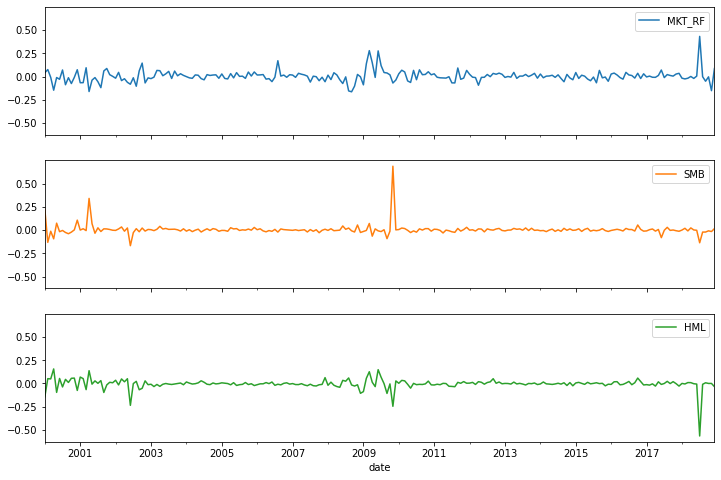

In [75]:
gammas.iloc[:, 1:4].plot(figsize = (12, 8), subplots = True, sharey = True, sharex = True)
plt.show()

The two spikes at the end of the sample signal potential colinearity issues; two factors seem to compensate in an unclear aggregate effect. This underlines the usefulness of penalized estimates.

### Factor Competition

- It's preferable if redundancies within factors are avoided (which implies collinearity).
- A simple protocol to sort out redundant factors is to run regressions of each factor against all others:
$$f_{t,k}=a_k+\sum_{j \neq k}\delta_{k,j}f_{t,j}+\varepsilon_{t,k}$$
- Preferably, $a_k$ should be statistically significant, otherwise this factor is redundant
- Below we replicate the analysis by Fama and French (2015) which shows that HML is redundant when taking into account other 4 factors (Market, SMB, RMW and CMA)

In [118]:
factors = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']
sub_FF_factors = FF_factors[factors]
def factor_redundancy_check(x):
    endog = x
    exog = FF_factors[list(set(factors) - set([x.name]))]
    fit = sm.OLS(endog, sm.add_constant(exog)).fit()
    
    def stars_significance(x):
        if(x < 0.001):
            return "(***)"
        elif(x < 0.01):
            return "(**)"
        elif(x < 0.05):
            return "(*)"
        return ""
    pvalues = fit.pvalues.apply(stars_significance)
    params = round(fit.params, 3).astype("str") + pvalues
    return params

params = sub_FF_factors.apply(factor_redundancy_check).T
display(params)

,CMA,HML,MKT_RF,RMW,SMB,const
MKT_RF,-0.945(***),0.12,NaN,-0.363(***),0.257(***),0.008(***)
SMB,-0.139,0.083,0.131(***),-0.435(***),NaN,0.003(*)
HML,1.027(***),NaN,0.032,0.169(***),0.044,-0.001
RMW,-0.319(***),0.165(***),-0.096(***),NaN,-0.225(***),0.004(***)
CMA,NaN,0.45(***),-0.112(***),-0.144(***),-0.032,0.002(***)


We confirm that the HML factor remains redundant when the four others are present in the asset pricing model. The figures we obtain are very close to the ones in the original paper (Fama and French (2015)), which makes sense, since we only add 5 years to their initial sample.

Sometimes, a 3-factor model may outperform a 5-factor one. See De Moor et al. (2015) that introduces a novel computation for p-values that compare the relative likelihood that two models pass a zero-alpha test. Recent researches suggests at least 15 factors.

### Advanced Techniques

The ever increasing number of factors combined to their importance in asset management has led researchers to craft more subtle methods in order to organize’’ the so-called factor zoo and, more importantly, to detect spurious anomalies and compare different asset pricing model specifications.

- Feng et al. (2020) combine LASSO selection with Fama-MacBeth regressions to test if new factor models are worth it. They quantify the gain of adding one new factor to a set of predefined factors and show that **many factors reported in papers published in the 2010 decade do not add much incremental value.**
- C. Harvey and Liu (2019): bootstrap on orthogonalized factors
- Fama and French (2018): compare asset pricing models through squared maximum Sharpe ratios
- Giglio and Xiu (2019): estimate factor risk premia using a three-pass method based on PCA
- Pukthuanthong, Roll, and Subrahmanyam (2018): disentangle priced and non-priced factors via a combination of PCA and Fama-MacBeth (1973) regressions.
- Gospodinov, Kan, and Robotti (2019): warn against factor misspecification (when spurious factors are included in the list of regressors). Traded factors (resp. macro-economic factors) seem more likely (resp. less likely) to yield robust identifications (see also Bryzgalova (2019)).

## Factors or Characteristics?

There are always debate over **whether firm returns are indeed explained by exposure to macro-economic factors** or simply by the characteristics of firms. Daniel and Titman (1997) provide evidence in favour of the former. They show that firms with high book-to-market ratios or small capitalizations display higher average returns, even if they are negatively loaded on the HML or SMB factors. Therefore, **it seems that it is indeed the intrinsic characteristics that matter, and not the factor exposure.**

See Page 28 of the original book for more reference papers.

## Hot Topics: Momentum, Timing and ESG

### Factor Momentum

A recent body of literature unveils a time series momentum property of factor returns. Gupta and Kelly (2019) report that autocorrelation patterns within these returns is statistically significant.

We may compute the ACF of factors with previous data. Recall that
$$ACF_k(\mathbf{x}_t)=\mathbb{E}[(\mathbf{x}_t-\bar{\mathbf{x}})(\mathbf{x}_{t+k}-\bar{\mathbf{x}})]$$

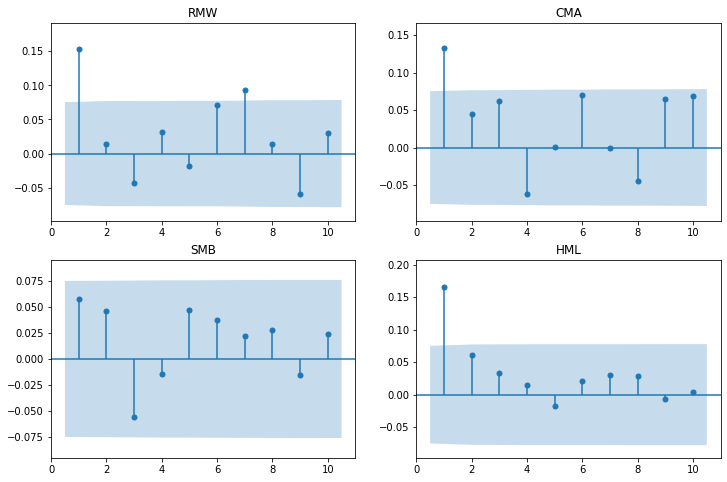

In [124]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplots(figsize = (12, 8))
ax = plt.subplot(221)
sm.graphics.tsa.plot_acf(FF_factors['RMW'], lags = np.arange(1, 11), title = 'RMW', ax = ax, auto_ylims = True)
ax = plt.subplot(222)
sm.graphics.tsa.plot_acf(FF_factors['CMA'], lags = np.arange(1, 11), title = 'CMA', ax = ax, auto_ylims = True)
ax = plt.subplot(223)
sm.graphics.tsa.plot_acf(FF_factors['SMB'], lags = np.arange(1, 11), title = 'SMB', ax = ax, auto_ylims = True)
ax = plt.subplot(224)
sm.graphics.tsa.plot_acf(FF_factors['HML'], lags = np.arange(1, 11), title = 'HML', ax = ax, auto_ylims = True)
plt.show()

Of the four chosen series, only the size factor (HML) is not significantly autocorrelated at the first order.

### Factor Timing

There is no consensus on predicting when factor will perform well or badly. **In ML-based factor investing, it is possible to resort to more granularity by combining firm-specific attributes to large-scale economic data.**

### Green Factors

Researches about whether or not characteristics related to ESG criteria (environment, social, governance) are priced. This topic is complex. However, **ESG criteria can directly be integrated into ML model**, as is for instance done in de Franco et al. (2020).

## The Links with Machine Learning

Given a large set of predictor variables ($\mathbf{X}$), the goal is to predict a proxy for future performance $y$ through a model. The general formulation is the following. At time $T$, the investor seeks to solve the following problem:
$$\max_{\mathbf{\theta}_T}\mathbb{E}_T[u(r_{p,T+1})]=\max_{\mathbf{\theta}_T}\mathbb{E}_T[u\left((\bar{\mathbf{w}}_T+\mathbf{x}_T\theta_T)'\mathbf{r}_{T+1} \right)]$$
where $u$ is some utility function, and $r_{p,T+1}=(\bar{\mathbf{w}}_T+\mathbf{x}_T\theta_T)'\mathbf{r}_{T+1}$ is the return of the portfolio, which is defined at a benchmark $\bar{\mathbf{w}}_T$ plus some deviations from this benchmark that are a linear function of features $\mathbf{x}_T\theta_T$. The aboce problems may be subject to some external constraints.

In practice, the vector $\theta_T$ must be estimated using past data (from $T-\tau$ to $T-1$). The agent seeks the solution of
$$\max_{\theta_T}\frac{1}{\tau} \sum_{t=T-\tau}^{T-1}u\left(\sum_{i=1}^{N_T} (\bar{w}_{i,t}+\theta_T^{'} \mathbf{x}_{i,t})r_{i,t+1}\right)$$
on a sample of size $\tau$ where $N_T$ is the number of assets. The above formulation can be viewed as **a learning task** in which the **parameters are chosen such that the reward (average return) is maximized**.

### A Short List of Recent References
Some ML approaches:

- Penalized Quadratic Programming
- Regularized Predictive Regressions
- Support Vector Machines (may be old-fashioned)
- Model Comparison and/or Aggregation

### Explicit Connections with Asset Pricing Models

The first and obvious link between factor investing and asset pricing is (average) return prediction. The general equation:
$$r_{t+1,n}=g(\mathbf{x}_{t,n})+\varepsilon_{t+1}$$
- Non-linear Function $g$: no reason (beyond simplicity and interpretability) to restrict the model to linear relationships
- Shift in time index: *prediction needs* instead of explanatory
- May also be interested in other predictors, like Sharpe Ratio
- $g$ can be estimated through some ML-related tools

One mainstream problem: **Stochastic Discount Factor (SDF)** $M_t$ which satisfies $\mathbb{E}_T[M_{t+1}(r_{t+1,n}-r_{t+1,f})]=0$ for any asset $n$. It's an example of the generalized method of moment: $M_t$ must be such that $$\mathbb{E}[M_{t+1}g(V_t)R_{t+1,n}]=0$$ where the instrumental variables $V_t$ are $\mathcal{F}_t$-measureable and the capital $R_{t+1,n}$ denotes the *excess* return of asset $n$. In order to reduce and simplify the estimation problem, it is customary to define the SDF as a portfolio of assets.

A second approach is to try to model asset returns as linear combinations of factors, just as above. We write in compact notation 
$$r_{t,n}=\alpha_n+\beta_{t,n}^{'}\mathbf{f}_t+\varepsilon_{t,n}$$
and we allow loadings $\beta_{t,n}$ to be time-dependent. We can incorporate market size, accounting ratios, past performance, etc. with some *long-short portfolios*. 

Feng et al. (2019) automates the process of factor construction using Deep Learning. **They apply a revised version of softmax function for long-short portfolios and use these portfolios to construct latent factors as an supplement to classical Fama-French factors.** It's a predictive model and could help explain a substantially larger proportfion of the in-sample variance in the returns.

A third approach is that of Kelly et al. (2019) with ideas that factors are **latent** and it is the betas that depend on characteristics. They estimate $\mathbf{f}_t$ and $\beta_{t,n}(\cdot)$ with some linear form.

A fourth approach introduced by Gu et al. (2020a) combines two neural network architectures. A first one takes $\mathbf{x}_{t-1}$ as inputs and generates factor loadings $\beta_{t-1}(\mathbf{x}_{t-1})$. The second one transforms returns $\mathbf{r}_t$ into factor values $\mathbf{f}_t(\mathbf{r}_t)$. The aggreagte model is $$\mathbf{r}_t=\beta_{t-1}(\mathbf{x}_{t-1})^{'}\mathbf{f}_t(\mathbf{r}_t)+\varepsilon_t$$
It's special because *the output is also present in the input*, like autoencoders.

**Conclusion**: The intersection between asset pricing and machine learning offers a rich variety of applications. However, it can be already exhaustive that it's often hard to disentangle noise from publications on these topics. **Practice and implementation is the only way forward to extricate value from hype.**

## Coding Exercises

1. Compute annual returns of the growth versus value portfolios, that is, the average return of firms with above median price-to-book ratio (the variable is called 'Pb' in the dataset)

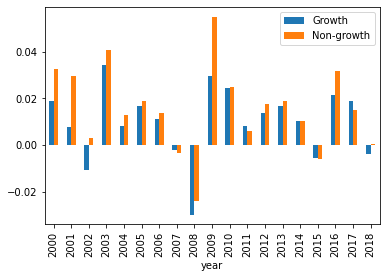

In [152]:
data_ml['Pb_rank'] = data_ml.groupby('year')['Pb'].rank(pct = True)
average_return_growth = data_ml[data_ml['Pb_rank'] >= 0.5].groupby('year')['R1M_Usd'].mean() # R1M OR R12M?
average_return_nongrowth = data_ml[data_ml['Pb_rank'] < 0.5].groupby('year')['R1M_Usd'].mean() # R1M OR R12M?
average_return = pd.DataFrame([average_return_growth, average_return_nongrowth], index = ['Growth', 'Non-growth']).T
average_return.plot.bar()
plt.show()

2. Same exercise, but compute the monthly returns and plot the value (through time) of the corresponding portfolios

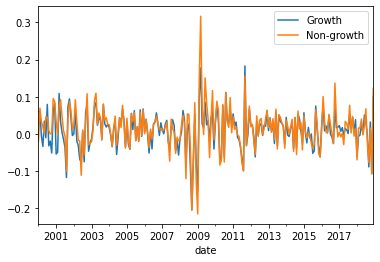

In [158]:
data_ml['Pb_rank'] = data_ml.groupby('date')['Pb'].rank(pct = True)
average_return_growth = data_ml[data_ml['Pb_rank'] >= 0.5].groupby('date')['R1M_Usd'].mean() # R1M OR R12M?
average_return_nongrowth = data_ml[data_ml['Pb_rank'] < 0.5].groupby('date')['R1M_Usd'].mean() # R1M OR R12M?
average_return = pd.DataFrame([average_return_growth, average_return_nongrowth], index = ['Growth', 'Non-growth']).T
average_return.plot()
plt.show()

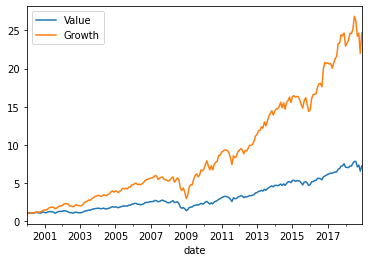

In [160]:
cum_return_growth = (1 + average_return_growth).cumprod()
cum_return_nongrowth = (1 + average_return_nongrowth).cumprod()
cum_return = pd.DataFrame([cum_return_growth, cum_return_nongrowth], index = ['Value', 'Growth']).T
cum_return.plot()
plt.show()

3. Instead of a unique threshold, compute simply sorted portfolios based on quartiles of market capitalization. Compute their annual returns and plot them.

<AxesSubplot:xlabel='year'>

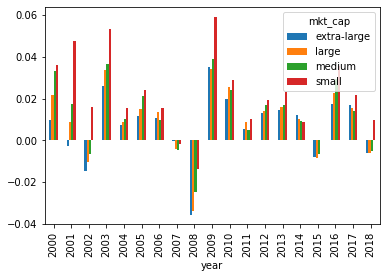

In [167]:
def mkt_cap(x):
    if(x <= 0.25):
        return "small"
    elif(x <= 0.5):
        return "medium"
    elif(x <= 0.75):
        return "large"
    else:
        return "extra-large"

data_ml['mkt_cap'] = data_ml['Mkt_Cap_12M_Usd'].apply(mkt_cap)
annual_group_return = data_ml.groupby(['year', 'mkt_cap'])['R1M_Usd'].mean().unstack()
annual_group_return.plot.bar()